# Imports

In [1]:
from ipywidgets import interact
from os import listdir
from copy import deepcopy
import pickle 
import time 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromPDBFile
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.rdmolops import GetSymmSSSR
from rdkit.Chem.rdmolfiles import MolFromPDBBlock
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

import frag_funcs 

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

remover = SaltRemover()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

import py3Dmol
import mols2grid




INFO:rdkit:Enabling RDKit 2020.03.3 jupyter extensions


Conformer generation funcitons (Joshua Myers code)

In [2]:
import Bio.PDB as PDB

def duplicate_conformers(m: Chem.rdchem.Mol, new_conf_idx: int, rms_limit: float = 0.5) -> bool:
    rmslist = []
    for i in range(m.GetNumConformers()):
        if i == new_conf_idx:
            continue
        rms = AllChem.GetConformerRMS(m, new_conf_idx, i, prealigned=True)
        rmslist.append(rms)
    return any(i < rms_limit for i in rmslist)


def get_mcs(mol_one: Chem.rdchem.Mol, mol_two: Chem.rdchem.Mol) -> str:
    """Code to find the maximum common substructure between two molecules."""
    return Chem.MolToSmiles(
        Chem.MolFromSmarts(
            rdFMCS.FindMCS([mol_one,mol_two], completeRingsOnly=True, matchValences=True).smartsString
        )
    )


def generate_conformers(mol, ref_mol, num_conf, ref_smi, minimum_conf_rms):
    # if SMILES to be fixed are not given, assume to the MCS
    if not ref_smi:
        ref_smi = get_mcs(mol, ref_mol)
    print('Aligning {}'.format(ref_smi))
    # Creating core of reference ligand #
    try:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(ref_smi))

        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol
    except Exception as ex:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(get_mcs(mol, ref_mol)))
        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,useRandomCoords=True,useTethers=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol
    
class ProteinLigandClashFilter:
    def __init__(self, protein_pdbpath: str, distance: float = 1.5):
        parser = PDB.PDBParser(QUIET=True, PERMISSIVE=True)
        s = parser.get_structure('protein', protein_pdbpath)
        self.kd = PDB.NeighborSearch(list(s.get_atoms()))
        self.radius = distance

    def __call__(self, conf: Chem.rdchem.Conformer) -> bool:
        for coord in conf.GetPositions():
            res = self.kd.search(coord, radius=self.radius)
            if len(res):
                return True
        return False

# MPro

In [3]:
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'

filenames = [ f for f in listdir(data_dir + '/frags/') if f[-5:]=='0.pdb']
df = pd.read_csv(data_dir + '/frags/hits_summary.csv')
df = df.set_index('Dataset')

frags = []
smiles_list = []
for f in tqdm(filenames):
    try:
        #read SMILES from .csv
        dataname = f[:-6]
        smiles = df.loc[dataname]['Compound SMILES']
        mol = AllChem.MolFromSmiles(smiles)
        mol = remover.StripMol(mol)
        smiles = MolToSmiles(mol)

        #read coords from PDB
        file = open(data_dir + '/frags/'+f, 'r')
        data = file.read().splitlines()
        ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
        pdbblock = ''.join(ligand)
        read_mol = MolFromPDBBlock(pdbblock)
        ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, read_mol)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        mol = generate_conformers(mol, ref_mol, 100, ref_smi = smiles, minimum_conf_rms=0.5)
        print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

#         #check for protein clashes
#         pdb_path = 'data/cov_and_noncov/'+dataname+'_0_new.pdb'
#         clash_filter = ProteinLigandClashFilter(pdb_path, distance=0.5)
#         for conf in mol.GetConformers():
#             if clash_filter(conf):
#                 confid = conf.GetId()
#                 print(f'removing conformer id: {confid}')
#                 mol.RemoveConformer(confid)
#         print('Remaining conformations after removing clashes: {}'.format(mol.GetNumConformers()))

        conf = mol.GetConformer()

        ligand_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            ligand_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]])

        frags.append(ligand_data)
        smiles_list.append(MolToSmiles(MolFromSmiles(smiles)))
#     hit_data.append(mol_row['Fluorescence avg IC50 (uM)'].values[0])

#     hits.append(hit_data)
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(smiles))
        print(ex)
print('Number of smiles: {}'.format(len(smiles_list)))
print('Number of unique smiles: {}'.format(len(set(smiles_list))))

  0%|          | 0/23 [00:00<?, ?it/s]

Aligning COC(=O)c1ccc(S(N)(=O)=O)cc1


  4%|▍         | 1/23 [00:01<00:37,  1.70s/it]

removed 82 duplicated conformations
Remaining conformations after removing duplicates: 18
Aligning O=C(NCCc1ccncc1)NC1CCCCC1


  9%|▊         | 2/23 [00:08<01:07,  3.22s/it]

removed 60 duplicated conformations
Remaining conformations after removing duplicates: 40
Aligning NC(=O)[C@H]1CCC[C@H]1c1ccsc1


 13%|█▎        | 3/23 [00:10<00:59,  2.96s/it]

removed 92 duplicated conformations
Remaining conformations after removing duplicates: 8
Aligning N#Cc1ccc(N2CCCOCC2)cn1


 17%|█▋        | 4/23 [00:13<00:53,  2.80s/it]

removed 87 duplicated conformations
Remaining conformations after removing duplicates: 13
Aligning CCNc1ccc(C#N)cn1


 22%|██▏       | 5/23 [00:14<00:40,  2.25s/it]

removed 88 duplicated conformations
Remaining conformations after removing duplicates: 12
Aligning Cc1cc(CN(C)C(=O)NC2CC2)no1


 26%|██▌       | 6/23 [00:18<00:47,  2.80s/it]

removed 42 duplicated conformations
Remaining conformations after removing duplicates: 58
Aligning CCC(=N)N


 30%|███       | 7/23 [00:18<00:33,  2.11s/it]

removed 76 duplicated conformations
Remaining conformations after removing duplicates: 24
Aligning O=C(Nc1ccccc1)Nc1cccnc1


 35%|███▍      | 8/23 [00:21<00:33,  2.22s/it]

removed 99 duplicated conformations
Remaining conformations after removing duplicates: 1
Aligning CN1CCN(C(=O)Cc2c[nH]c3ncccc23)CC1


 39%|███▉      | 9/23 [00:26<00:43,  3.09s/it]

removed 63 duplicated conformations
Remaining conformations after removing duplicates: 37
Aligning N#Cc1ccc(CNC(=O)N2CCOCC2)cc1


 43%|████▎     | 10/23 [00:30<00:43,  3.32s/it]

removed 90 duplicated conformations
Remaining conformations after removing duplicates: 10
Aligning Cc1nnc(CN2CCC=C(F)C2)s1


 48%|████▊     | 11/23 [00:32<00:36,  3.00s/it]

removed 71 duplicated conformations
Remaining conformations after removing duplicates: 29
Aligning Cc1ccc(OCC(=O)N2CCN(C)CC2)cc1


 52%|█████▏    | 12/23 [00:37<00:39,  3.62s/it]

removed 33 duplicated conformations
Remaining conformations after removing duplicates: 67
Aligning Nc1cncnc1


 57%|█████▋    | 13/23 [00:37<00:26,  2.66s/it]

removed 98 duplicated conformations
Remaining conformations after removing duplicates: 2
Aligning CN1CCCc2ccc(S(N)(=O)=O)cc21


 61%|██████    | 14/23 [00:40<00:23,  2.65s/it]

removed 69 duplicated conformations
Remaining conformations after removing duplicates: 31
Aligning CC(=O)Nc1cnccc1C


 65%|██████▌   | 15/23 [00:42<00:18,  2.28s/it]

removed 66 duplicated conformations
Remaining conformations after removing duplicates: 34
Aligning CC(=O)NCCc1c[nH]c2ccc(F)cc12


 70%|██████▉   | 16/23 [00:45<00:18,  2.62s/it]

removed 86 duplicated conformations
Remaining conformations after removing duplicates: 14
Aligning O=C(NCCc1ccncc1)c1ccccc1F


 74%|███████▍  | 17/23 [00:49<00:17,  2.95s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr


 78%|███████▊  | 18/23 [00:54<00:18,  3.61s/it]

removed 73 duplicated conformations
Remaining conformations after removing duplicates: 27
Aligning CS(=O)(=O)c1ccc(N2CCNCC2)cc1


 83%|████████▎ | 19/23 [00:57<00:14,  3.54s/it]

removed 68 duplicated conformations
Remaining conformations after removing duplicates: 32
Aligning NS(=O)(=O)c1ccc(Br)cc1


 87%|████████▋ | 20/23 [00:58<00:08,  2.71s/it]

removed 97 duplicated conformations
Remaining conformations after removing duplicates: 3
Aligning O=C(CC1CCCCC1)Nc1cccnc1


 91%|█████████▏| 21/23 [01:01<00:05,  2.94s/it]

removed 65 duplicated conformations
Remaining conformations after removing duplicates: 35
Aligning CS(=O)(=O)NCCc1ccccc1


 96%|█████████▌| 22/23 [01:04<00:02,  2.70s/it]

removed 81 duplicated conformations
Remaining conformations after removing duplicates: 19
Aligning OC1CCN(Cc2ccsc2)CC1


100%|██████████| 23/23 [01:06<00:00,  2.87s/it]

removed 75 duplicated conformations
Remaining conformations after removing duplicates: 25
Number of smiles: 23
Number of unique smiles: 23


In [ ]:
### NEW DATA READING 11/05/2021 (file_dir change 2/9/2021)
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'

df_activity = pd.read_csv(data_dir + '/activity_data-2.csv')

df_activity['acrylamide'] = df_activity['acrylamide'].fillna(False)
df_activity['chloroacetamide'] = df_activity['chloroacetamide'].fillna(False)

print('Length of raw df_activity :{}'.format(len(df_activity)))

df_activity = df_activity[(~df_activity['acrylamide']) & (~df_activity['chloroacetamide'])]

print('Length of non-covalent df_activity :{}'.format(len(df_activity)))

df_compounds = pd.read_csv(data_dir + '/Mpro_compound_tracker_csv.csv').rename(columns={'Compound ID': 'CID'})
df_compounds = df_compounds[df_compounds['Status']=='Completed']
df_compounds = df_compounds[df_compounds['Dataset'].notna()]

print('Length of df_compounds :{}'.format(len(df_compounds)))

df_activity = pd.merge(df_activity, df_compounds, on='CID')
df_activity = df_activity.drop_duplicates(subset='CID')

print('Length of merged df_activity :{}'.format(len(df_activity)))

print('Number of actives :{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

hits = []
ids = []

bad_ids = []

for i,row in tqdm(df_activity.iterrows(), total=len(df_activity)):
    
    try:
        mol_path = data_dir + '/aligned/'+row['Dataset']+'_0A/'+row['Dataset']+'_0A.pdb'
        mol_pdb = Chem.MolFromPDBFile(mol_path)

        mol = MolFromSmiles(row['SMILES_x'])
        ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, mol_pdb)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        mol = generate_conformers(mol, ref_mol, 100, ref_smi = row['SMILES_x'], minimum_conf_rms=0.5)
        print('Remaining conformations after removing duplicates: {}'.format(mol.GetNumConformers()))

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        hit_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            hit_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        hit_data.append(row['f_avg_IC50'])

        hits.append(hit_data)
        ids.append(row['CID'])
        
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(row['SMILES_x']))
        print(ex)
        
        bad_ids.append(row['CID'])
        
df_activity = df_activity[~df_activity['CID'].isin(bad_ids)]

print('Number of bad mols :{}'.format(len(bad_ids)))

print('{} hits left'.format(len(hits)))
print('{} hits left'.format(len(df_activity)))

print('Number of actives left:{}'.format(len(df_activity[df_activity['f_avg_IC50']<5])))

# with open('hits_may.list', 'wb') as pickle_file:
#     pickle.dump(hits, pickle_file)

In [4]:
# with open('hits_new.list', 'wb') as pickle_file:
#     pickle.dump(hits, pickle_file)
data_dir = '/home/wjm41/ml_physics/plot_frags/'

with open(data_dir + 'all_ligands.list', 'rb') as pickle_file:
    frags = pickle.load(pickle_file)
# with open('hits.list', 'rb') as pickle_file:
#     hits = pickle.load(pickle_file)
with open(data_dir + 'hits_new.list', 'rb') as pickle_file:
    hits = pickle.load(pickle_file)
print(len(frags))

23


In [ ]:
filenames = [ f for f in listdir('data/frags/') if f[-5:]=='0.pdb']
df = pd.read_csv('data/frags/Mpro_hits_summary.csv')
df = df.set_index('Dataset')

mols = []
hit_mols = []
smiles_list = []
name_list = []

for f in filenames:
    dataname = f[:-6]

    smiles = df.loc[dataname]['Compound SMILES']
    mol = AllChem.MolFromSmiles(smiles)
    mols.append(mol)
    smiles_list.append(MolToSmiles(mol))
    name_list.append(dataname)

print('Number of noncovalent binding frags: {}'.format(len(mols)))

mol_df = pd.DataFrame({"mol": mols,
                   "name": name_list})
mols2grid.display(mol_df, mol_col='mol', subset=['img', 'name'], selection=True, n_cols =4)

In [ ]:
for hit in hits:
    tmp = hit[0]
    tmp = Chem.RemoveHs(tmp)
    AllChem.Compute2DCoords(tmp)
    hit_mols.append(tmp)
print('Number of hits: {}'.format(len(hits)))
# Draw.MolsToGridImage(hit_mols, molsPerRow=6, subImgSize=(275,275), legends=ids)
Draw.MolsToGridImage(hit_mols, molsPerRow=6, subImgSize=(275,275))

SingleAtomDonor
(0,)
SingleAtomDonor
(7,)
SingleAtomDonor
(14,)
SingleAtomAcceptor
(2,)
SingleAtomAcceptor
(9,)
SingleAtomAcceptor
(17,)


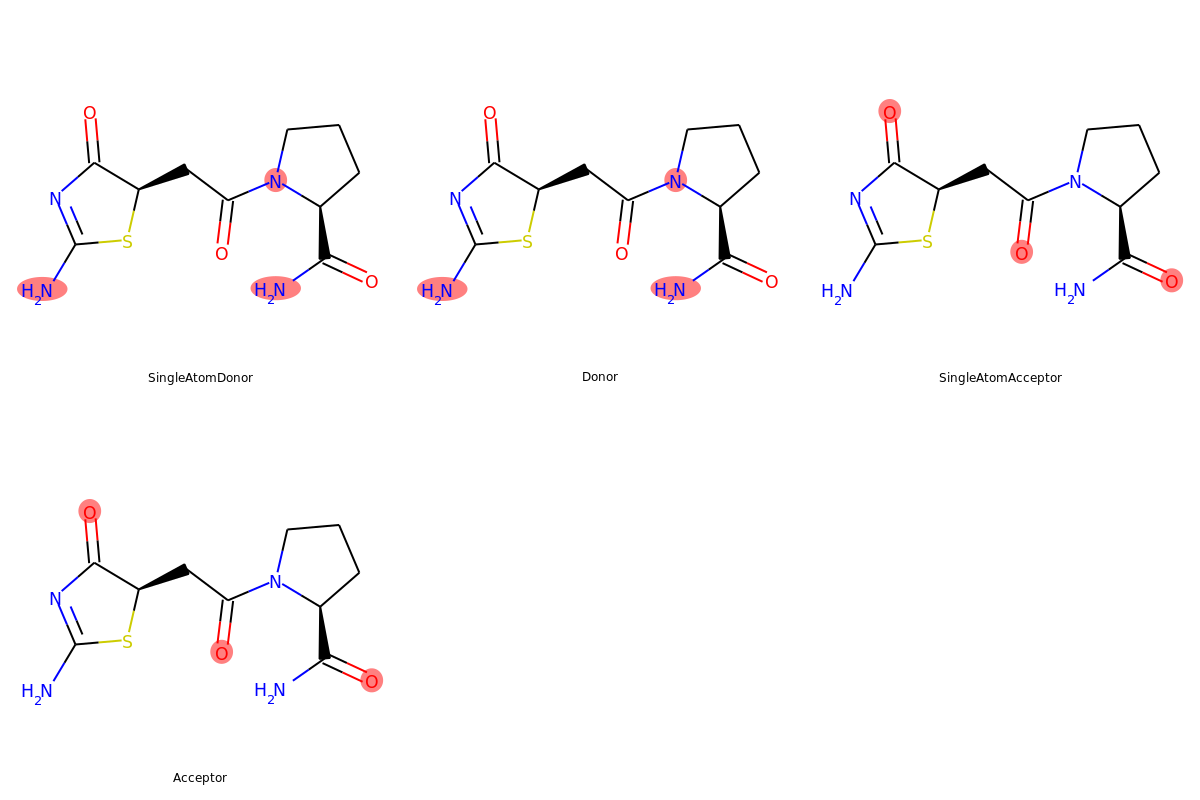

In [5]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

def drawp4core(mol, draw=False):
    atoms_list = {}
    feats = featFactory.GetFeaturesForMol(mol)
    for feat in feats:
        feat_type = feat.GetType()
        feat_fam = feat.GetFamily()
        if feat_fam in interesting_pcores:
            atom_ids = feat.GetAtomIds()

            print(feat_type)
            print(atom_ids)
            if feat_type in atoms_list:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] += atom_ids
    #             else:
                    atoms_list[feat_type] += atom_ids
            else:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] = atom_ids
    #             else:
                    atoms_list[feat_type] = atom_ids
            if feat_fam in atoms_list:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] += atom_ids
    #             else:
                    atoms_list[feat_fam] += atom_ids
            else:
    #             if feat_type=='Aromatic':
    #                 atoms_list[feat_type] = atom_ids
    #             else:
                    atoms_list[feat_fam] = atom_ids

    if draw:
        AllChem.Compute2DCoords(mol)
        return Draw.MolsToGridImage([mol]*len(atoms_list), subImgSize=(400,400),legends=list(atoms_list.keys()), highlightAtomLists=list(atoms_list.values()))
    else:
        return atoms_list
test = Chem.MolFromSmiles('[H]N([H])C(=O)[C@@H]1CCCN1C(=O)C[C@H]1SC(N([H])[H])=NC1=O')
    
i=1
# im = drawp4core(hits[15][0], draw=True)
im = drawp4core(test, draw=True)
im

In [ ]:
p4core_list = drawp4core(hits[0][0])
print(p4core_list)
frag_p4core_ids = []
hit_p4core_ids = []
for frag in frags:
    frag_p4core_ids.append(drawp4core(frag[0]))
for hit in hits:
    hit_p4core_ids.append(drawp4core(hit[0]))

# Sanity check plotting

In [2]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

colors = {'Donor': 'O', 'Acceptor': 'N', 'Aromatic': 'Cl'}

mpro_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'

frags = pickle.load(open(mpro_dir + '/frags_mpro.pickle', 'rb'))

frag_df = frag_funcs.return_pcore_dataframe(frags, interesting_pcores)
frag_df = frag_df[['pcore', 'coord_x', 'coord_y', 'coord_z']]
frag_df['pcore'] = [colors[x] for x in frag_df['pcore']]
frag_df['coord_x'] = frag_df['coord_x'].astype(str)
frag_df['coord_y'] = frag_df['coord_y'].astype(str)
frag_df['coord_z'] = frag_df['coord_z'].astype(str)


100%|██████████| 23/23 [00:01<00:00, 15.79it/s]


In [33]:
def MolTo3DView(mol, size=(1000, 1000), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    
    return viewer


In [41]:
from rdkit import Chem
from rdkit.Chem import AllChem


def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

smi = 'O=C(NC1CCOCC1)C(c1cncnc1)N(C(=O)c1csnn1)C1CCN(c2ccccc2F)C1'
mol = smi2conf(smi)

def get_xyz_from_mol(mol):
  """Extracts a numpy array of coordinates from a molecules.
  Returns a `(N, 3)` numpy array of 3d coords of given rdkit molecule
  Parameters
  ----------
  mol: rdkit Molecule
    Molecule to extract coordinates for
  Returns
  -------
  Numpy ndarray of shape `(N, 3)` where `N = mol.GetNumAtoms()`.
  """
  xyz = np.zeros((mol.GetNumAtoms(), 3))
  conf = mol.GetConformer()
  for i in range(conf.GetNumAtoms()):
    position = conf.GetAtomPosition(i)
    xyz[i, 0] = position.x
    xyz[i, 1] = position.y
    xyz[i, 2] = position.z
  return (xyz)

centroid = np.mean(get_xyz_from_mol(frags[2][0]), axis=0)

from rdkit.Geometry import Point3D
conf = mol.GetConformer()
for i in range(mol.GetNumAtoms()):
    position = conf.GetAtomPosition(i)
    x,y,z = position.x+centroid[0], position.y+centroid[1], position.z+centroid[2]
    conf.SetAtomPosition(i,Point3D(x,y,z))



In [44]:
viewer = MolTo3DView(mol, size=(1000, 1000), style='sphere')
file = open(mpro_dir+'/6YB7_model.pdb', 'r')
protein = file.read()
# viewer.addModel(protein, 'pdb')
# viewer.setStyle({'model': 1}, {'cartoon': {'color': 'grey', 'opacity': 0.5}})
# viewer.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})
# viewer.setBackgroundColor('white')
viewer.show()
# viewer.svg()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
view = py3Dmol.view(width=1000, height=1000)

data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data'
file = open(mpro_dir+'/6YB7_model.pdb', 'r')
protein = file.read()
# view.addModel(protein, 'pdb')

for mol in frags:
    mb = Chem.MolToMolBlock(Chem.RemoveHs(mol[0]), confId=-1)
    view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
# view.setStyle({'model': 0}, {'cartoon': {'color': 'grey', 'opacity': 0.5}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})
view.setBackgroundColor('white')
view.zoomTo()
view.show()
# time.sleep(10)
view.svg()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# 3D Pharmacophore Plotting

### Legend

In [9]:
colors = {'Donor': 'O', 'Acceptor': 'N', 'Aromatic': 'Cl'}

def plot_legend(r):
    view = py3Dmol.view()
    
    for n in range(3):
        
        legend = str(1)+'\n\n'
        legend = legend + \
            colors[list(colors)[n]]+' 0 ' + ' 0 '\
            +str(n)+'\n'
        view.addModel(legend, 'xyz')
        view.setStyle({'model': -1}, {'sphere': {'radius': r, 'opacity': 0.95}})
    view.setBackgroundColor('0xffffff')
    view.zoomTo()
    view.show()
    return None

interact(plot_legend, r=(0.1, 1.0, 0.1))  # (min, max, step)
# plot_legend(r=0.1)


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, min=0.1), Output()), _dom_classes=('wid…

<function __main__.plot_legend(r)>

In [11]:

def plot_3d(r, protein=False):
    view = py3Dmol.view()
    if protein:
        file = open(mpro_dir+'/6YB7_model.pdb', 'r')
        mpro = file.read()
        view.addModel(mpro, 'pdb')
        view.setStyle({'model': -1}, {'cartoon': {'color': 'yellow', 'opacity': 0.5}})

    frag_pcores = str(len(frag_df))+'\n\n'
    vol_data = []
    for i, row in frag_df.iterrows():
        vol_data.append(row['pcore']+' '+row['coord_x'] +
                        ' '+row['coord_y']+' '+row['coord_z'])
        frag_pcores = frag_pcores + \
            row['pcore']+' '+row['coord_x']+' ' + \
            row['coord_y']+' '+row['coord_z']+'\n'
    view.addModel(frag_pcores, 'xyz')
    view.setStyle({'model': -1}, {'sphere': {'radius': r, 'opacity': 0.95}})
    view.setBackgroundColor('0xffffff')
#     view.addSurface(py3Dmol.MS, {'opacity': 1.0})
    view.zoomTo()
    view.show()
    return None


interact(plot_3d, r=(0.1, 1.0, 0.1), protein=True)  # (min, max, step)


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, min=0.1), Checkbox(value=True, descript…

<function __main__.plot_3d(r, protein=False)>

In [6]:

def plot_3d(r, n, protein=False):
    view = py3Dmol.view()
    if protein:
        file = open(mpro_dir+'/6YB7_model.pdb', 'r')
        mpro = file.read()
        view.addModel(mpro, 'pdb')
        view.setStyle(
            {'model': -1}, {'cartoon': {'color': 'yellow', 'opacity': 0.5}})

    for i, row in frag_df.iterrows():
        frag_pcores = str(1)+'\n\n' + \
            row['pcore']+' '+row['coord_x']+' ' + \
            row['coord_y']+' '+row['coord_z']+'\n'
        view.addModel(frag_pcores, 'xyz')
        if i==0:
            view.setStyle(
                {'model': -1}, {'sphere': {'radius': r, 'color':'red', 'opacity': 1.0}})
        elif i==n:
            view.setStyle(
                {'model': -1}, {'sphere': {'radius': r, 'color': 'blue', 'opacity': 1.0}})
        else:
            view.setStyle(
                {'model': -1}, {'sphere': {'radius': r, 'color': 'grey', 'opacity': 0.75}})
    view.setBackgroundColor('0xffffff')
#     view.addSurface(py3Dmol.MS, {'opacity': 1.0})
    view.zoomTo({'model':n})
    view.show()
    return None


interact(plot_3d, r=(0.1, 1.0, 0.1), n=(
    0, len(frag_df)-1, 1), protein=False)  # (min, max, step)


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, min=0.1), IntSlider(value=53, descripti…

<function __main__.plot_3d(r, n, protein=False)>

In [13]:
frag_p4cores = []
for a in frag_p4core_ids:
    for p4core_i in a:
        if p4core_i not in frag_p4cores:
            frag_p4cores.append(p4core_i)
        
possible_pairs = []
for i, p4core_i in enumerate(frag_p4cores):
    for p4core_j in frag_p4cores[i:]:
        possible_pairs.append([p4core_i, p4core_j])
        
possible_trips = []
for i, p4core_i in enumerate(frag_p4cores):
    for j, p4core_j in enumerate(frag_p4cores[i:]):
        for k, p4core_k in enumerate(frag_p4cores[i+j:]):
            possible_trips.append([p4core_i, p4core_j, p4core_k])